In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential, Model

# Работа с датасетом рукописных цифр MNIST.

In [2]:
from tensorflow.keras.datasets.mnist import load_data

In [3]:
(X_train, y_train), (X_test, _) = load_data()

11501568/11490434 [==============================] - 10s 1us/step


In [4]:
X_train.shape

(60000, 28, 28)

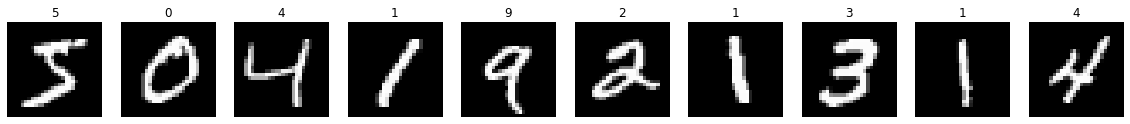

In [5]:
num = 10
fig, ax = plt.subplots(1, num, figsize=(20,5))
for i in range(num):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(y_train[i])
plt.show()

Предобработка. Каждое значение из диапазона [0,255] переводится в дипапзон [-1,1].

In [6]:
X_train_proc = 2*X_train.reshape(X_train.shape[0],-1) / 255 - 1
X_test_proc = 2*X_train.reshape(X_test.shape[0],-1) / 255 - 1

Создание нейронной сети. Отдельно создаются енкодер и декодер, затем объединяются в одну модель автокодировщика.

In [7]:
encoder = Sequential()
encoder.add(L.InputLayer(28*28))
encoder.add(L.Dense(28*28, activation='relu'))
encoder.add(L.Dense(64))
encoder.add(L.Dense(32))

In [8]:
decoder = Sequential()
decoder.add(L.InputLayer((32,)))
decoder.add(L.Dense(32))
decoder.add(L.Dense(64))
decoder.add(L.Dense(28*28))

In [9]:
inp = L.Input(28*28)
code = encoder(inp)
reconstruction = decoder(code)
model = Model(inputs=inp, outputs=reconstruction)

In [10]:
model.compile(optimizer='adamax', loss='mse')

In [11]:
model.fit(X_train_proc, X_train_proc, epochs=10, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0662
Epoch 2/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0331
Epoch 3/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0246
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0217
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0205
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0198
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0194
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0193
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0193
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0192


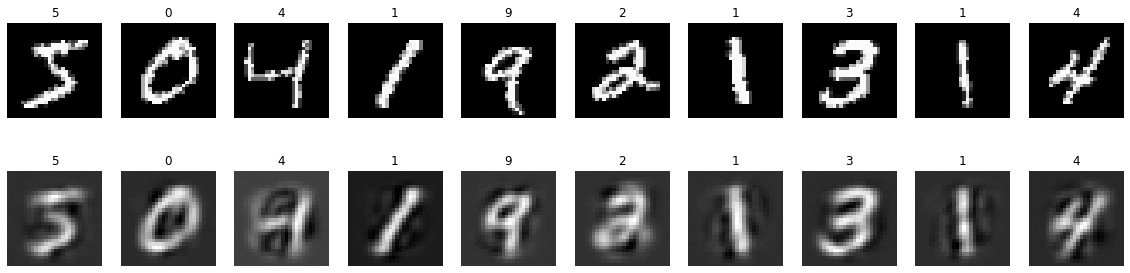

In [12]:
num = 10
fig, ax = plt.subplots(2, num, figsize=(20,5))
for i in range(num):
    ax[0][i].imshow(X_train_proc[i].reshape(28,28), cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title(y_train[i])
    ax[1][i].imshow(model.predict(X_train_proc[i].reshape(1,-1)).reshape(28,28), cmap='gray')
    ax[1][i].axis('off')
    ax[1][i].set_title(y_train[i])
plt.show()

# Автокодировщики с использованием сверточных сетей

In [146]:
encoder_conv = Sequential()
encoder_conv.add(L.InputLayer((28, 28, 1)))

encoder_conv.add(L.Conv2D (16, (3,3), padding='same', activation='relu'))
encoder_conv.add(L.MaxPooling2D(pool_size=(2, 2), padding='same'))

encoder_conv.add(L.Conv2D (8, (3,3), padding='same', activation='relu'))
encoder_conv.add(L.MaxPooling2D(pool_size=(2, 2), padding='same'))

encoder_conv.add(L.Flatten())
encoder_conv.add(L.Dense(32, activation='sigmoid'))

In [147]:
encoder_conv.compile(optimizer='adam', loss='mse')

In [148]:
encoder_conv.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_40 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 392)               0         
                                                                 
 dense_22 (Dense)            (None, 32)              

In [152]:
decoder_conv = Sequential()

decoder_conv.add(L.InputLayer((32,)))
decoder_conv.add(L.Dense(392, activation='relu'))
decoder_conv.add(L.Reshape((7,7,-1)))

decoder_conv.add(L.Conv2D(7, kernel_size=(3,3), padding='same', activation='relu'))
decoder_conv.add(L.UpSampling2D((2, 2)))

decoder_conv.add(L.Conv2D(14, kernel_size=(3,3), padding='same', activation='relu'))
decoder_conv.add(L.UpSampling2D((2, 2)))

decoder_conv.add(L.Conv2D(1, (3,3), activation='tanh', padding='same'))

In [153]:
decoder_conv.compile(optimizer='adam', loss='mse')

In [154]:
decoder_conv.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 392)               12936     
                                                                 
 reshape_18 (Reshape)        (None, 7, 7, 8)           0         
                                                                 
 conv2d_42 (Conv2D)          (None, 7, 7, 7)           511       
                                                                 
 up_sampling2d_10 (UpSamplin  (None, 14, 14, 7)        0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 14, 14, 14)        896       
                                                                 
 up_sampling2d_11 (UpSamplin  (None, 28, 28, 14)       0         
 g2D)                                                

In [155]:
inp = L.Input(shape=(28, 28, 1))
code = encoder_conv(inp)
reconstruction_conv = decoder_conv(code)
model_conv = Model(inputs=inp, outputs=reconstruction_conv)

In [156]:
model_conv.compile(optimizer='adamax', loss='mse')

In [157]:
X_train_proc = X_train / 255 * 2 - 1
X_test_proc = X_test / 255 * 2 - 1

In [168]:
model_conv.fit(X_train_proc, X_train_proc, epochs=10, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0541
Epoch 2/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0468
Epoch 3/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0423
Epoch 4/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0393
Epoch 5/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0370
Epoch 6/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0354
Epoch 7/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0341
Epoch 8/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0331
Epoch 9/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0323
Epoch 10/10
1875/1875 [==============================] - 63s 33ms/step - loss: 0.0316


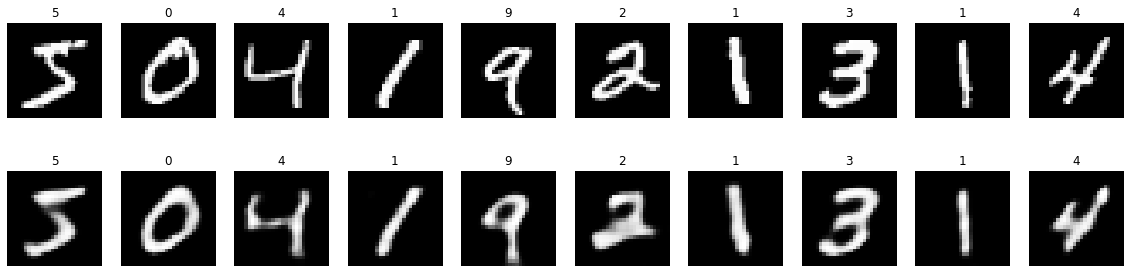

In [160]:
num = 10
fig, ax = plt.subplots(2, num, figsize=(20,5))
for i in range(num):
    ax[0][i].imshow(X_train[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title(y_train[i])
    ax[1][i].imshow(model_conv.predict(X_train_proc[i:i+1]).reshape(28,28), cmap='gray')
    ax[1][i].axis('off')
    ax[1][i].set_title(y_train[i])
plt.show()

# Генератор случайных изображений

In [166]:
inputs_ = L.Input(32)
outputs_ = decoder(inputs_)
gen_model = Model(inputs=inputs_, outputs=outputs_)

outputs_conv_ = decoder_conv(inputs_)
gen_model_conv = Model(inputs=inputs_, outputs=outputs_conv_)

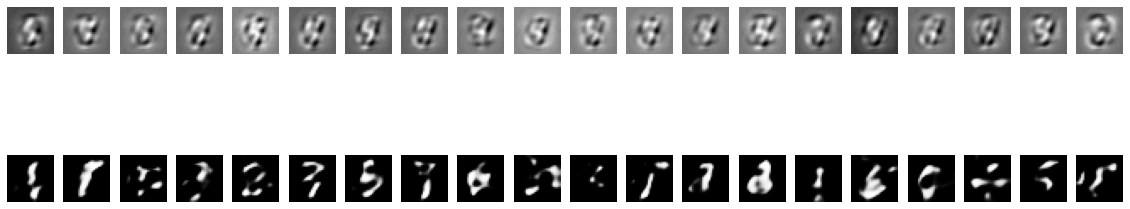

In [167]:
num = 20
fig, ax = plt.subplots(2, num, figsize=(20,5))
for i in range(num):
    rnd_inp = np.random.random(32)

    result = gen_model.predict(rnd_inp.reshape(1,-1))
    ax[0][i].imshow(result.reshape(28,28), cmap='gray')
    ax[0][i].axis('off')

    result = gen_model_conv.predict(rnd_inp.reshape(1,-1))
    ax[1][i].imshow(result.reshape(28,28), cmap='gray')
    ax[1][i].axis('off')
      
plt.show()

Цифры, которые генерирует сверточный автокодиривщик, более правдоподобные.

# Автокодировщик для лиц

Использовать датасет LWF http://vis-www.cs.umass.edu/lfw/

# Найти похожие картинки

Использовать датасет LWF http://vis-www.cs.umass.edu/lfw/

# Полезные ссылки

- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz